In [6]:
import cv2
from pycocotools.coco import COCO
from pathlib import Path
from matplotlib import pyplot as plt
path = Path.cwd()


train_json = path / 'datasets/detection/annotations/instances_val.json'
train_path = path / 'datasets/detection/val'

def visualization_bbox(num_image, json_path, img_path):
    coco = COCO(json_path)

    list_imgIds = coco.getImgIds() # 获取含有该给定类别的所有图片的id
    img = coco.loadImgs(list_imgIds[num_image-1])[0]  # 获取满足上述要求，并给定显示第num幅image对应的dict
    image = cv2.imread(img_path +'/'+ img['file_name'])  # 读取图像
    image_name =  img['file_name'] # 读取图像名字
    image_id = img['id'] # 读取图像id

    img_annIds = coco.getAnnIds(imgIds=image_id)
    img_anns = coco.loadAnns(img_annIds)

    for i in range(len(img_annIds)):
        # if img_anns[i]["filename"] == "132.jpg"
        x, y, w, h = img_anns[i]['bbox']  # 读取边框
        image = cv2.rectangle(image, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 255), 2)

    plt.rcParams['figure.figsize'] = (20.0, 20.0)
    plt.imshow(image)
    plt.show()

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


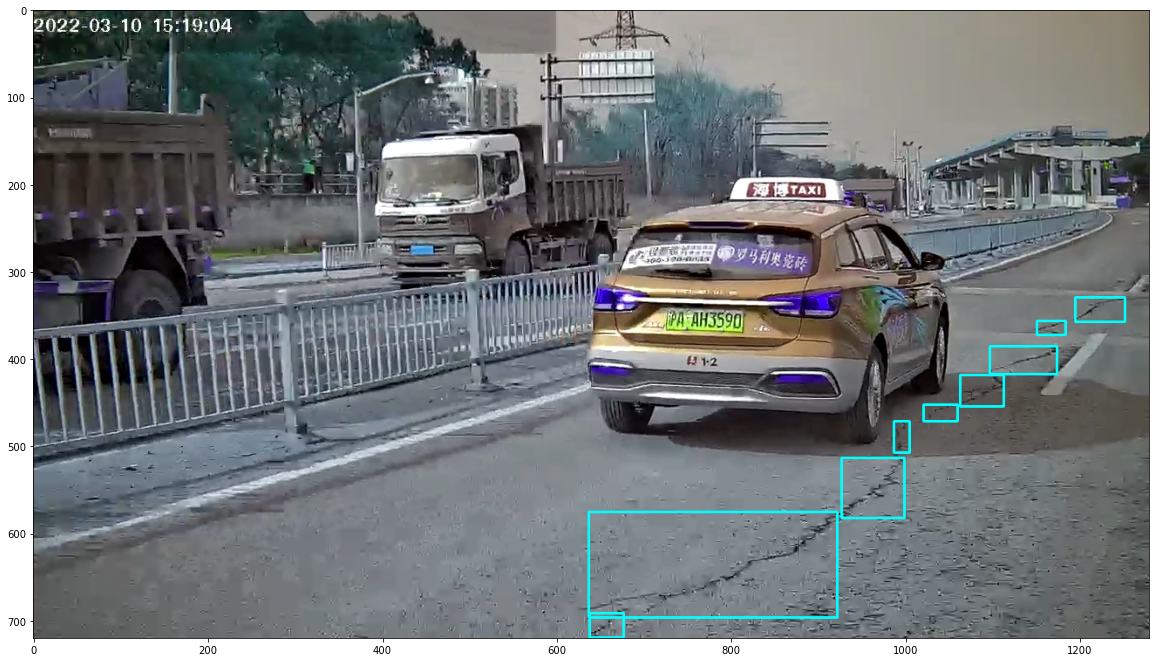

In [32]:
visualization_bbox(4,str(train_json),str(train_path))

In [2]:
! python train.py -c 2 -p detection --batch_size 8 --lr 5e-3 --num_epochs 30 \
 --load_weights weights/efficientdet-d2.pth --debug True --head_only True

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
[Warning] Ignoring Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 112, 1, 1]) from checkpoint, the shape in current model is torch.Size([36, 112, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([810]) from checkpoint, the shape in current model is torch.Size([36]).
[Warning] Don't panic if you see this, this might be because you load a pretrained weights with different number of classes. The rest of the weights should be loaded already.
[Info] loaded weights: efficientdet-d2.pth, resuming checkpoint from step: 0
[Info] freezed backbone
Step: 36. Epoch: 0/30. Iteration: 37/37. Cls loss: 1.33802. Reg loss: 3.59502. T
Val. Epoch: 0/30. Classificatio

In [36]:
! python coco_eval.py -c 2 -p detection -w 'logs/detection/efficientdet-d2_189_7000.pth'

running coco-style evaluation on project detection, weights logs/detection/efficientdet-d2_189_7000.pth...
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
100%|███████████████████████████████████████████| 75/75 [00:08<00:00,  8.92it/s]
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
BBox
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.00s).
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=   all | maxDets=100 ] = 0.475
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= small | maxDets=100 ] = 0.431
 Average Precision  (AP) @[ IoU=0.50:0.50 | area=medium | maxDets=100 ] = 0.802
 Average Precision  (AP) @[ IoU=0.50:0.50 | area= large | maxDets=100 ] = -1.000
 Average Recall     (AR) @[ I

In [2]:
import torch
from torch.backends import cudnn

from backbone import EfficientDetBackbone
import cv2
import matplotlib.pyplot as plt
import numpy as np

from efficientdet.utils import BBoxTransform, ClipBoxes

from utils.utils import preprocess, invert_affine, postprocess

/home/mazheng/miniconda3/envs/eff/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


/home/mazheng/miniconda3/envs/eff/lib/python3.7/site-packages/ipykernel_launcher.py:68: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


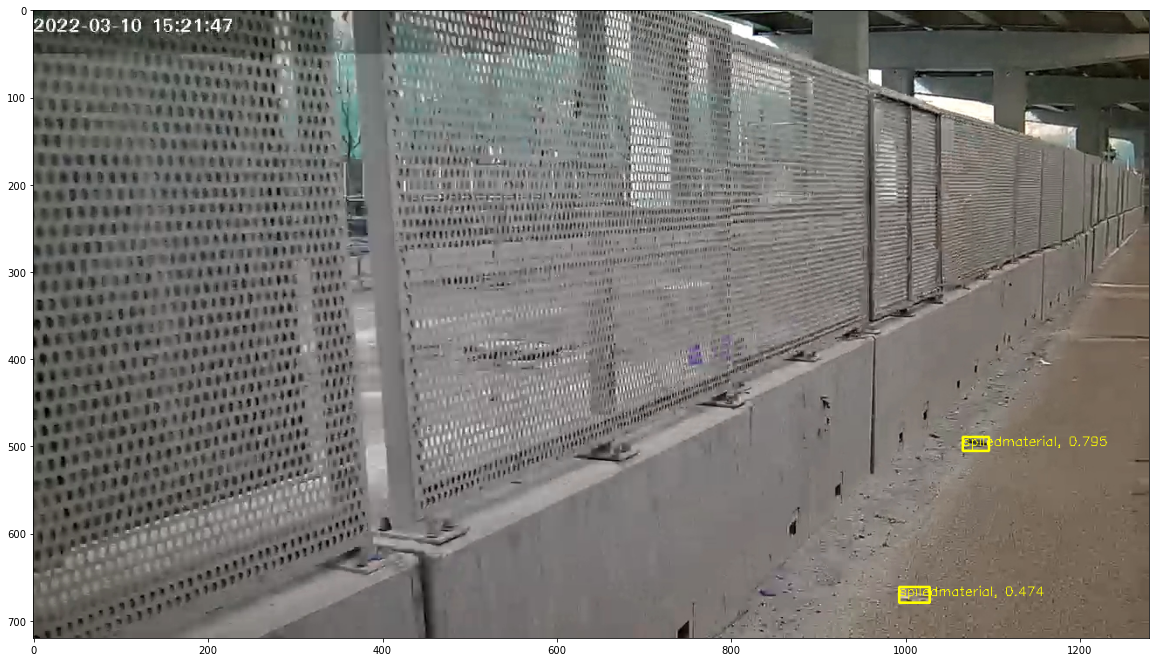

In [33]:
compound_coef = 2
force_input_size = None  # set None to use default size
img_path = '/home/mazheng/waste-detection/Yet-Another-EfficientDet-Pytorch/datasets/detection/val/sp132.jpg'

threshold = 0.2
iou_threshold = 0.2

use_cuda = True
use_float16 = False
cudnn.fastest = True
cudnn.benchmark = True


obj_list = ["spiledmaterial", "person", "crack", "potholes"]

# tf bilinear interpolation is different from any other's, just make do
input_sizes = [512, 640, 768, 896, 1024, 1280, 1280, 1536]
input_size = input_sizes[compound_coef] if force_input_size is None else force_input_size
ori_imgs, framed_imgs, framed_metas = preprocess(img_path, max_size=input_size)

if use_cuda:
    x = torch.stack([torch.from_numpy(fi).cuda() for fi in framed_imgs], 0)
else:
    x = torch.stack([torch.from_numpy(fi) for fi in framed_imgs], 0)

x = x.to(torch.float32 if not use_float16 else torch.float16).permute(0, 3, 1, 2)

model = EfficientDetBackbone(compound_coef=compound_coef, num_classes=len(obj_list),

                             # replace this part with your project's anchor config
                             ratios=[(0.6, 1.5), (1.2, 0.8), (1.7, 0.6)],
                             scales=[(2 ** 0)/2, (2 ** (1.0 / 3.0))/2, (2 ** (2.0 / 3.0))/2])
                            # scales=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)])

model.load_state_dict(torch.load('logs/detection/efficientdet-d2_121_4500.pth'))
model.requires_grad_(False)
model.eval()

if use_cuda:
    model = model.cuda()
if use_float16:
    model = model.half()

with torch.no_grad():
    features, regression, classification, anchors = model(x)

    # print(classification)

    regressBoxes = BBoxTransform()
    clipBoxes = ClipBoxes()

    out = postprocess(x,
                      anchors, regression, classification,
                      regressBoxes, clipBoxes,
                      threshold, iou_threshold)
# print(out)
# print(x.shape[0])
out = invert_affine(framed_metas, out)

# print(out)

for i in range(len(ori_imgs)):
    if len(out[i]['rois']) == 0:
        # print(len(ori_imgs))
        continue
    ori_imgs[i] = ori_imgs[i].copy()
    for j in range(len(out[i]['rois'])):
        (x1, y1, x2, y2) = out[i]['rois'][j].astype(np.int)
        cv2.rectangle(ori_imgs[i], (x1, y1), (x2, y2), (255, 255, 0), 2)
        obj = obj_list[out[i]['class_ids'][j]]
        score = float(out[i]['scores'][j])

        cv2.putText(ori_imgs[i], '{}, {:.3f}'.format(obj, score),
                    (x1, y1 + 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5,
                    (255, 255, 0), 1)

        plt.imshow(ori_imgs[i])